In [2]:
import pandas as pd # type: ignore
from datetime import datetime # type: ignore
import numpy as np #type: ignore

import matplotlib # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.metrics import mean_squared_error # type: ignore
from sklearn.utils.fixes import parse_version
from sklearn.inspection import permutation_importance

In [3]:
df = pd.read_csv('datasets/dataset_PS.csv')
df = df.astype({'date': 'datetime64[ns]'})
# df.drop(columns=['irradiation', 'cloudiness', 'holiday', 'precipitation'], inplace=True)
df['shift_1y'] = df['consumption'].shift(24*365-2)
df['shift_1w'] = df['consumption'].shift(24*7)
df['shift_2d'] = df['consumption'].shift(24*2)
df['hour'] = df['date'].dt.hour
df['weekDay'] = df['date'].dt.weekday

# sort by holidays
df = df.sort_values(by='holiday')

holidays_map = {holiday: i for i, holiday in enumerate(df['holiday'].unique())}
df['holiday'] = df['holiday'].map(holidays_map)

# sort holidays
df = df.sort_values(by='date')
df.index = df['date']
df.drop(columns=['date'], inplace=True)

df = df.fillna(df.mean())
df

,consumption_eles_forecast,consumption,temperature,precipitation,irradiation,price,volumes,cloudiness,holiday,shift_1y,shift_1w,shift_2d,hour,weekDay
date,,,,,,,,,,,,,,
2022-01-01 01:00:00,953.0,1018.0,-3.2,0.0,0.0,51.44327,1084.700,37.0,7,1321.915402,1294.735295,1293.223639,1,5
2022-01-01 02:00:00,906.0,975.0,-3.9,0.0,0.0,55.91396,1071.100,37.0,7,1321.915402,1294.735295,1293.223639,2,5
2022-01-01 03:00:00,874.0,944.0,-2.8,0.0,0.0,46.94279,1065.700,37.0,7,1321.915402,1294.735295,1293.223639,3,5
2022-01-01 04:00:00,870.0,936.0,-3.1,0.0,0.0,37.67210,1062.800,37.0,7,1321.915402,1294.735295,1293.223639,4,5
2022-01-01 05:00:00,892.0,952.0,-4.1,0.0,0.0,39.70000,1070.000,37.0,7,1321.915402,1294.735295,1293.223639,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-04 19:00:00,1045.0,1262.0,13.8,0.0,0.0,183.82000,1629.500,83.0,0,1334.000000,1462.000000,1214.000000,19,0
2024-11-04 20:00:00,1045.0,1262.0,13.8,0.0,0.0,143.15000,1561.226,83.0,0,1287.000000,1385.000000,1162.000000,20,0
2024-11-04 21:00:00,1045.0,1262.0,13.8,0.0,0.0,118.17000,1606.500,83.0,0,1183.000000,1235.000000,1069.000000,21,0


In [9]:
# test eles accuracy
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error # type: ignore
from sktime.performance_metrics.forecasting import mean_squared_percentage_error # type: ignore

mse = root_mean_squared_error(df['consumption'].tail(24*30), df['consumption_eles_forecast'].tail(24*30))
mae = mean_absolute_error(df['consumption'].tail(24*30), df['consumption_eles_forecast'].tail(24*30))
mape = mean_absolute_percentage_error(df['consumption'].tail(24*30), df['consumption_eles_forecast'].tail(24*30))
rmspe = mean_squared_percentage_error(df['consumption'].tail(24*30), df['consumption_eles_forecast'].tail(24*30), square_root=True)

plt_title = 'MAE: {0:.2f}, RMSE: {1:.2f}, MAPE: {2:.2f}, RMSPE: {3:.2f}'.format(mae, mse, mape*100, rmspe*100)

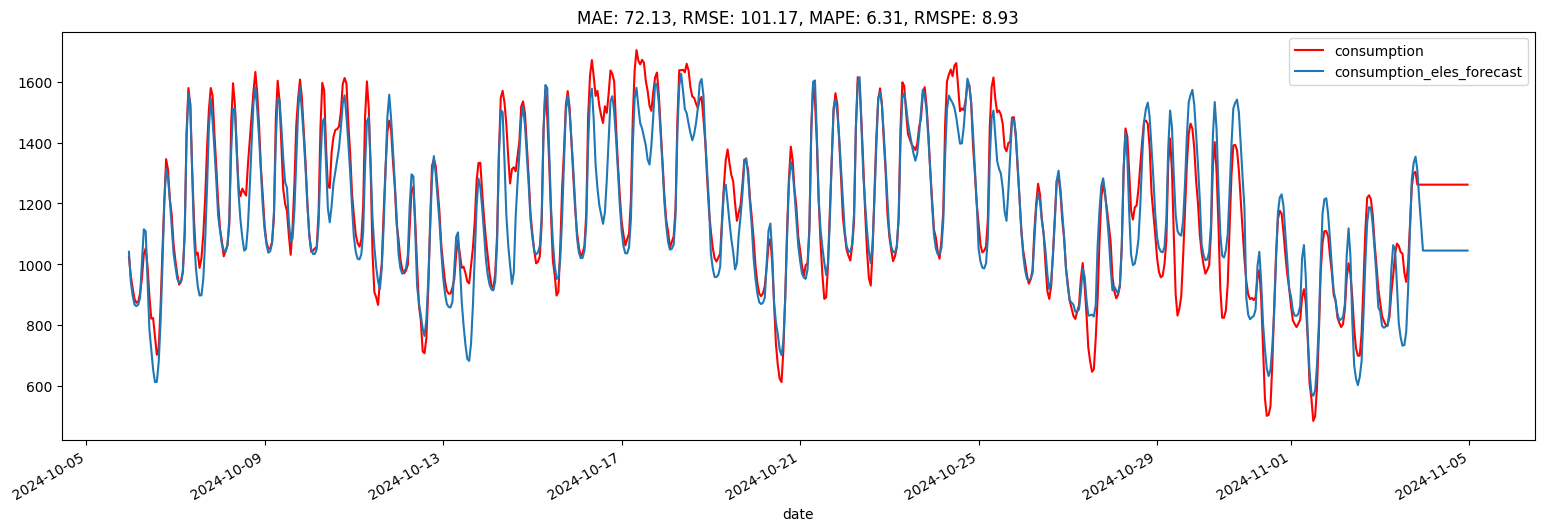

In [12]:
df['consumption'].tail(24*30).plot(title=plt_title,figsize=(19, 6),legend=True, color='red')
ax = df['consumption_eles_forecast'].tail(24*30).plot(title=plt_title,figsize=(19, 6), legend=True)

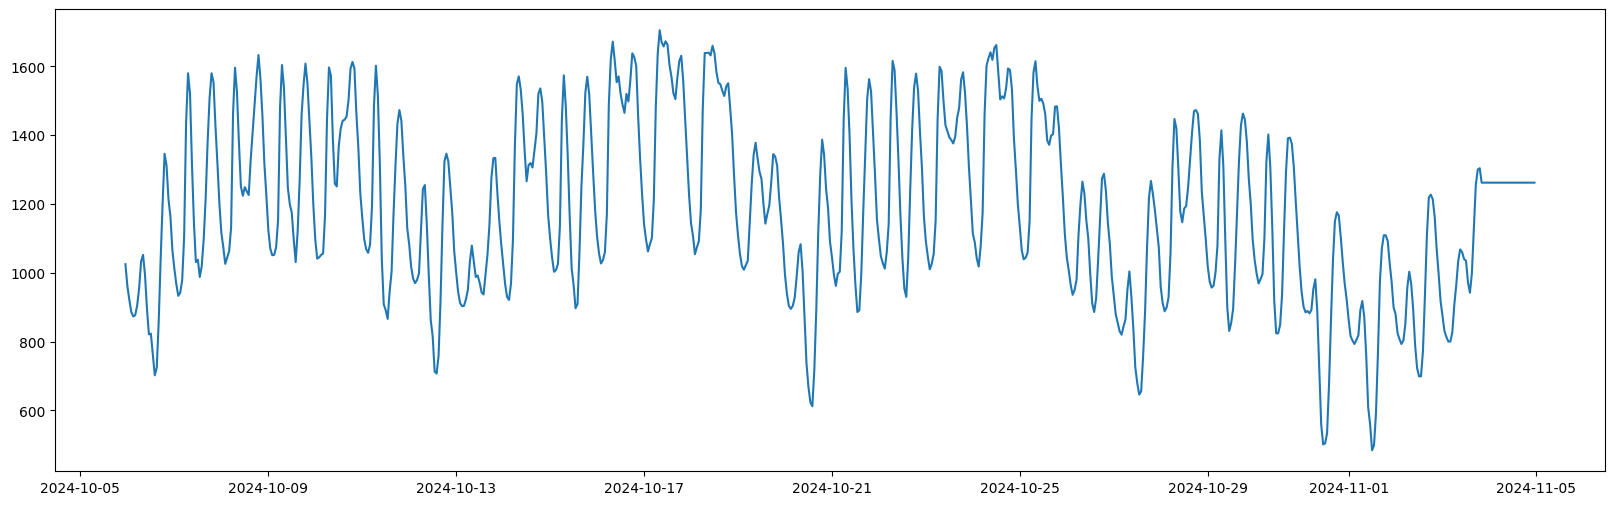

In [6]:
figure = plt.figure(figsize=(20, 6))
plt.plot(df['consumption'].tail(24*30))

In [13]:
from sklearn.ensemble import GradientBoostingRegressor # type: ignore
from sklearn.metrics import mean_absolute_percentage_error # type: ignore

df_hourly = df.copy()

# Split the dataset based on the cutoff date
cutoff_date = '2024-10-01 00:00:00'
train_data = df_hourly[df_hourly.index < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly.index >= cutoff_date]

In [14]:
test_data = test_data.iloc[:-24]
test_data

,consumption_eles_forecast,consumption,temperature,precipitation,irradiation,price,volumes,cloudiness,holiday,shift_1y,shift_1w,shift_2d,hour,weekDay
date,,,,,,,,,,,,,,
2024-10-01 00:00:00,1132.0,1149.0,5.8,0.0,0.0,3.21,842.200,80.0,0,864.0,1117.0,960.0,0,1
2024-10-01 01:00:00,1083.0,1073.0,5.6,0.0,0.0,0.07,779.600,80.0,0,824.0,1066.0,928.0,1,1
2024-10-01 02:00:00,1066.0,1048.0,5.4,0.0,0.0,0.05,708.700,80.0,0,788.0,1039.0,899.0,2,1
2024-10-01 03:00:00,1068.0,1062.0,5.3,0.0,0.0,0.02,699.900,80.0,0,795.0,1068.0,860.0,3,1
2024-10-01 04:00:00,1093.0,1060.0,4.8,0.0,0.0,0.09,847.100,80.0,0,798.0,1079.0,861.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-03 19:00:00,1354.0,1304.0,13.8,0.0,0.0,123.00,1688.000,83.0,0,1481.0,1267.0,1109.0,19,6
2024-11-03 20:00:00,1309.0,1262.0,13.8,0.0,0.0,112.90,1959.700,83.0,0,1412.0,1229.0,1092.0,20,6
2024-11-03 21:00:00,1212.0,1262.0,13.8,0.0,0.0,109.37,1276.654,83.0,0,1292.0,1183.0,1027.0,21,6


In [15]:
# X_train = train_data[['shifted_consumption_168','hour','weekDay','shifted_consumption_48', 'temperature', 'holiday', 'cloudiness', 'precipitation', 'irradiation', 'Price']]
# X_test = test_data[['shifted_consumption_168','hour','weekDay','shifted_consumption_48', 'temperature', 'holiday', 'cloudiness', 'precipitation', 'irradiation', 'Price']]

X_train = train_data[['shift_1w','hour','weekDay','shift_2d', 'holiday', 'volumes', 'price', 'shift_1y', 'consumption_eles_forecast']]
X_test = test_data[['shift_1w','hour','weekDay','shift_2d', 'holiday', 'volumes', 'price', 'shift_1y', 'consumption_eles_forecast']]
y_train = train_data['consumption']
y_test = test_data['consumption']

reg = GradientBoostingRegressor(random_state=0,
								learning_rate=0.1,
								n_estimators=200,
								max_depth=5, 
								min_samples_split=10)
reg.fit(X_train, y_train)
forecast = pd.Series(reg.predict(X_test), index=X_test.index, name='consumption')

In [16]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error # type: ignore
from sktime.performance_metrics.forecasting import mean_squared_percentage_error # type: ignore

mse = root_mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
mape = mean_absolute_percentage_error(y_test, forecast)
rmspe = mean_squared_percentage_error(y_test, forecast, square_root=True)

plt_title = 'MAE: {0:.2f}, RMSE: {1:.2f}, MAPE: {2:.2f}, RMSPE: {3:.2f}'.format(mae, mse, mape*100, rmspe*100)

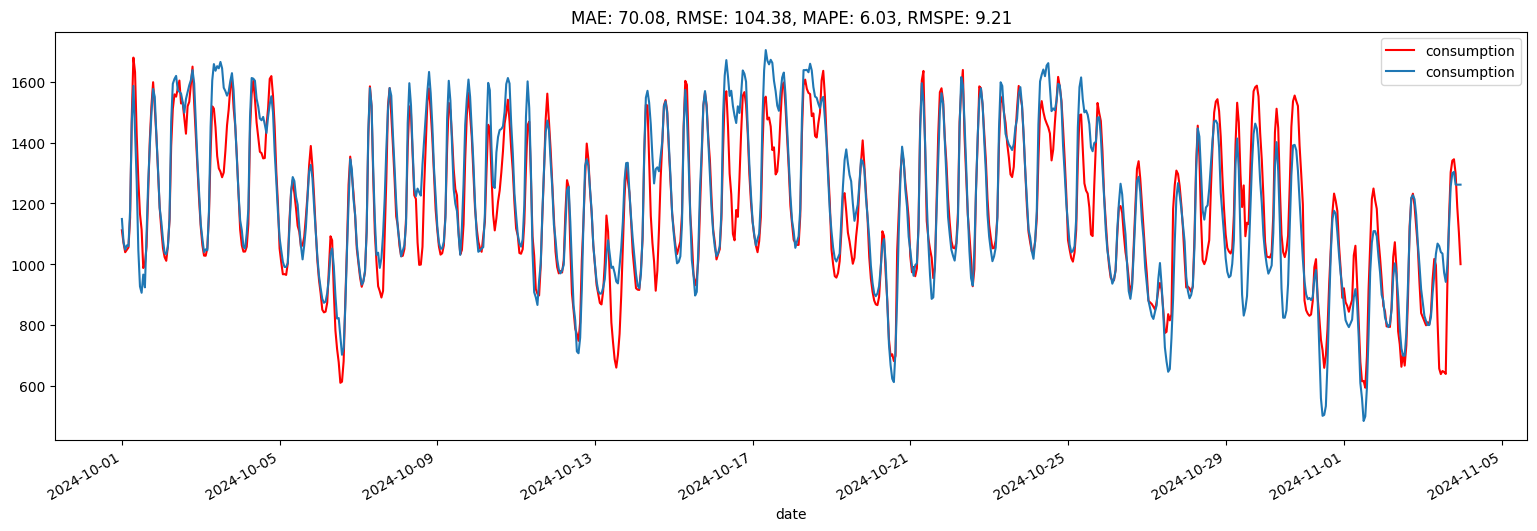

In [17]:
# forecast.index = date['date']
# y_test.index = date['date']
forecast.plot(title=plt_title,figsize=(19, 6),legend=True, color='red')
ax = y_test.plot(title=plt_title,figsize=(19, 6), legend=True)
# add date to plot as x axis

#### Feature importance

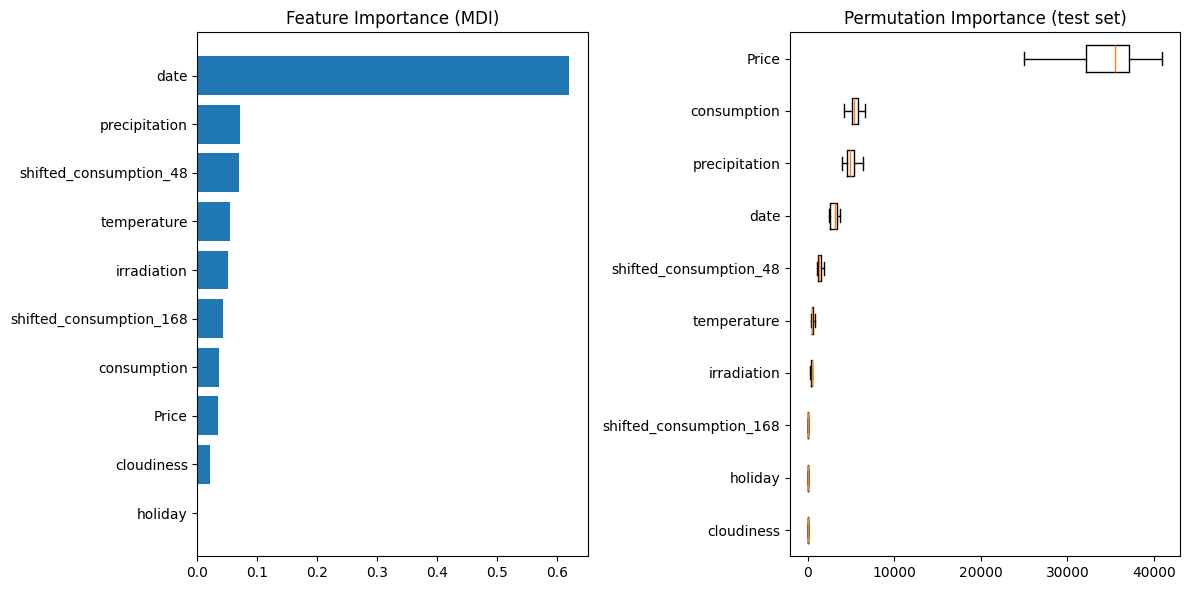

In [64]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df_hourly.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, forecast, n_repeats=10, random_state=0, n_jobs=2, 
	scoring='neg_mean_squared_error'
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)

# `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
# renamed to `tick_labels`. The following code handles this, but as a
# scikit-learn user you probably can write simpler code by using `labels=...`
# (matplotlib < 3.9) or `tick_labels=...` (matplotlib >= 3.9).
tick_labels_parameter_name = (
    "tick_labels"
    if parse_version(matplotlib.__version__) >= parse_version("3.9")
    else "labels"
)
tick_labels_dict = {
    tick_labels_parameter_name: np.array(df_hourly.columns)[sorted_idx]
}
plt.boxplot(result.importances[sorted_idx].T, vert=False, **tick_labels_dict)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### HistGradientBoostingRegressor

In [118]:
from sklearn.ensemble import HistGradientBoostingRegressor

reg = HistGradientBoostingRegressor(random_state=0,
									learning_rate=0.01,
									loss='squared_error',
									max_iter=5000)
reg.fit(X_train, y_train)
forecast = pd.Series(reg.predict(X_test), index=X_test.index, name='consumption')

In [119]:
mse = root_mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
mape = mean_absolute_percentage_error(y_test, forecast)
rmspe = mean_squared_percentage_error(y_test, forecast, square_root=True)

plt_title = 'MAE: {0:.2f}, RMSE: {1:.2f}, MAPE: {2:.2f}, RMSPE: {3:.2f}'.format(mae, mse, mape*100, rmspe*100)

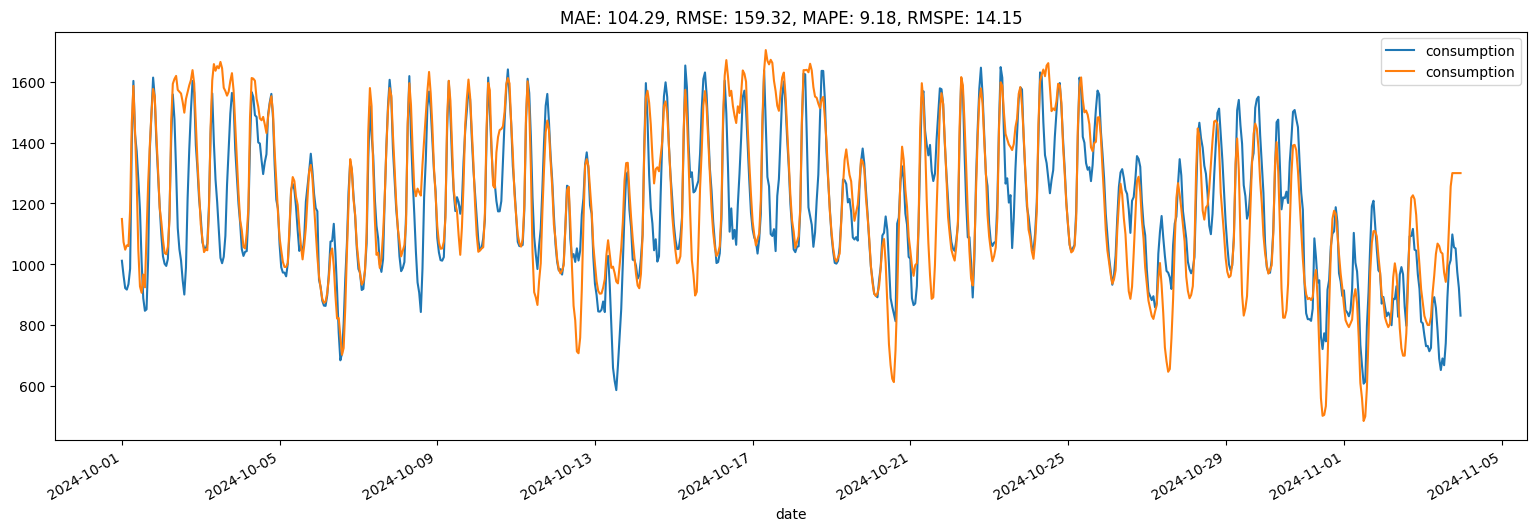

In [120]:
# forecast.index = date['date']
# y_test.index = date['date']
forecast.plot(title=plt_title,figsize=(19, 6),legend=True)
ax = y_test.plot(title=plt_title,figsize=(19, 6), legend=True)
# add date to plot as x axis

In [32]:
forecast.to_csv('output_file.csv', header=False,sep=',')
forecast

date
2024-10-01 00:00:00    1076.873283
2024-10-01 01:00:00    1043.351008
2024-10-01 02:00:00    1017.055376
2024-10-01 03:00:00     980.826345
2024-10-01 04:00:00    1012.039785
                          ...     
2024-11-02 19:00:00    1020.439618
2024-11-02 20:00:00    1023.739013
2024-11-02 21:00:00     933.470083
2024-11-02 22:00:00     890.552321
2024-11-02 23:00:00     838.804762
Name: consumption, Length: 791, dtype: float64

#### Grid searching for hyperparameter optimization

In [69]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Define the GBR model
gbr = GradientBoostingRegressor()

# Perform grid search
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_
print("Best model:", best_model)

# Evaluate the best model
forecast = best_model.predict(X_test)
mse = root_mean_squared_error(y_test, forecast)
print("RMSE:", mse)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


KeyboardInterrupt: 

```
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best model: GradientBoostingRegressor(max_depth=5, min_samples_split=10, n_estimators=200)
RMSE: 103.08038690634775
```

#### Train for tommorow

In [121]:
from sklearn.ensemble import GradientBoostingRegressor # type: ignore
from sklearn.metrics import mean_absolute_percentage_error # type: ignore

df_hourly = df.copy()

In [122]:
df_hourly.tail()

,consumption_eles_forecast,consumption,temperature,precipitation,irradiation,price,volumes,cloudiness,holiday,shift_1y,shift_1w,shift_2d,hour,weekDay
date,,,,,,,,,,,,,,
2024-11-04 19:00:00,2078.0,1300.0,13.8,0.0,0.0,183.82,1629.500,83.0,0,1334.0,1462.0,1214.0,19,0
2024-11-04 20:00:00,2078.0,1300.0,13.8,0.0,0.0,143.15,1561.226,83.0,0,1287.0,1385.0,1162.0,20,0
2024-11-04 21:00:00,2078.0,1300.0,13.8,0.0,0.0,118.17,1606.500,83.0,0,1183.0,1235.0,1069.0,21,0
2024-11-04 22:00:00,2078.0,1300.0,13.8,0.0,0.0,108.33,1445.700,83.0,0,1082.0,1166.0,997.0,22,0
2024-11-04 23:00:00,2078.0,1300.0,13.8,0.0,0.0,98.20,1128.500,83.0,0,1004.0,1098.0,918.0,23,0


In [123]:
# train_data in entire dataset
cutoff_date = '2024-11-04 00:00:00'
train_data = df_hourly[df_hourly.index < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly.index >= cutoff_date]

In [124]:
train_data

,consumption_eles_forecast,consumption,temperature,precipitation,irradiation,price,volumes,cloudiness,holiday,shift_1y,shift_1w,shift_2d,hour,weekDay
date,,,,,,,,,,,,,,
2022-01-01 01:00:00,953.0,1018.0,-3.2,0.0,0.0,51.44327,1084.700,37.0,7,1321.915402,1294.735295,1293.223639,1,5
2022-01-01 02:00:00,906.0,975.0,-3.9,0.0,0.0,55.91396,1071.100,37.0,7,1321.915402,1294.735295,1293.223639,2,5
2022-01-01 03:00:00,874.0,944.0,-2.8,0.0,0.0,46.94279,1065.700,37.0,7,1321.915402,1294.735295,1293.223639,3,5
2022-01-01 04:00:00,870.0,936.0,-3.1,0.0,0.0,37.67210,1062.800,37.0,7,1321.915402,1294.735295,1293.223639,4,5
2022-01-01 05:00:00,892.0,952.0,-4.1,0.0,0.0,39.70000,1070.000,37.0,7,1321.915402,1294.735295,1293.223639,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-03 19:00:00,2700.0,1300.0,13.8,0.0,0.0,123.00000,1688.000,83.0,0,1481.000000,1267.000000,1109.000000,19,6
2024-11-03 20:00:00,2611.0,1300.0,13.8,0.0,0.0,112.90000,1959.700,83.0,0,1412.000000,1229.000000,1092.000000,20,6
2024-11-03 21:00:00,2415.0,1300.0,13.8,0.0,0.0,109.37000,1276.654,83.0,0,1292.000000,1183.000000,1027.000000,21,6


In [125]:
test_data

,consumption_eles_forecast,consumption,temperature,precipitation,irradiation,price,volumes,cloudiness,holiday,shift_1y,shift_1w,shift_2d,hour,weekDay
date,,,,,,,,,,,,,,
2024-11-04 00:00:00,2078.0,1300.0,13.8,0.0,0.0,92.04,504.500,83.0,0,1060.0,959.0,880.0,0,0
2024-11-04 01:00:00,2078.0,1300.0,13.8,0.0,0.0,89.96,424.700,83.0,0,998.0,912.0,825.0,1,0
2024-11-04 02:00:00,2078.0,1300.0,13.8,0.0,0.0,90.07,663.700,83.0,0,972.0,888.0,807.0,2,0
2024-11-04 03:00:00,2078.0,1300.0,13.8,0.0,0.0,90.02,444.500,83.0,0,959.0,899.0,793.0,3,0
2024-11-04 04:00:00,2078.0,1300.0,13.8,0.0,0.0,90.93,524.600,83.0,0,943.0,928.0,803.0,4,0
2024-11-04 05:00:00,2078.0,1300.0,13.8,0.0,0.0,99.03,833.700,83.0,0,997.0,1055.0,851.0,5,0
2024-11-04 06:00:00,2078.0,1300.0,13.8,0.0,0.0,125.99,1288.800,83.0,0,1138.0,1306.0,957.0,6,0
2024-11-04 07:00:00,2078.0,1300.0,13.8,0.0,0.0,141.63,1138.900,83.0,0,1231.0,1447.0,1003.0,7,0
2024-11-04 08:00:00,2078.0,1300.0,13.8,0.0,0.0,136.46,642.900,83.0,0,1261.0,1420.0,967.0,8,0


In [127]:
X_train = train_data[['shift_1w','hour','weekDay','shift_2d', 'holiday', 'volumes', 'price', 'shift_1y']]
X_test = test_data[['shift_1w','hour','weekDay','shift_2d', 'holiday', 'volumes', 'price', 'shift_1y']]
y_train = train_data['consumption']
y_test = test_data['consumption']

from sklearn.ensemble import HistGradientBoostingRegressor

reg = HistGradientBoostingRegressor(random_state=0,
									learning_rate=0.1,
									loss='squared_error',
									max_iter=5000)

# reg = GradientBoostingRegressor(random_state=0,
# 								learning_rate=0.1,
# 								n_estimators=500,
# 								max_depth=10, 
# 								min_samples_split=10)
reg.fit(X_train, y_train)

HistGradientBoostingRegressor(max_iter=5000, random_state=0)

In [128]:
forecast = pd.Series(reg.predict(X_test), index=X_test.index, name='consumption')
forecast

date
2024-11-04 00:00:00     923.199450
2024-11-04 01:00:00     884.073005
2024-11-04 02:00:00     861.391799
2024-11-04 03:00:00     860.145384
2024-11-04 04:00:00     854.003500
2024-11-04 05:00:00     983.426397
2024-11-04 06:00:00    1309.148491
2024-11-04 07:00:00    1410.015416
2024-11-04 08:00:00    1359.516822
2024-11-04 09:00:00    1159.278783
2024-11-04 10:00:00    1222.848795
2024-11-04 11:00:00    1146.073516
2024-11-04 12:00:00    1179.339631
2024-11-04 13:00:00    1189.610864
2024-11-04 14:00:00    1222.581638
2024-11-04 15:00:00    1297.356524
2024-11-04 16:00:00    1387.853826
2024-11-04 17:00:00    1521.347229
2024-11-04 18:00:00    1539.858418
2024-11-04 19:00:00    1506.581131
2024-11-04 20:00:00    1440.281598
2024-11-04 21:00:00    1279.336297
2024-11-04 22:00:00    1184.030786
2024-11-04 23:00:00    1064.788460
Name: consumption, dtype: float64

<Axes: xlabel='date'>

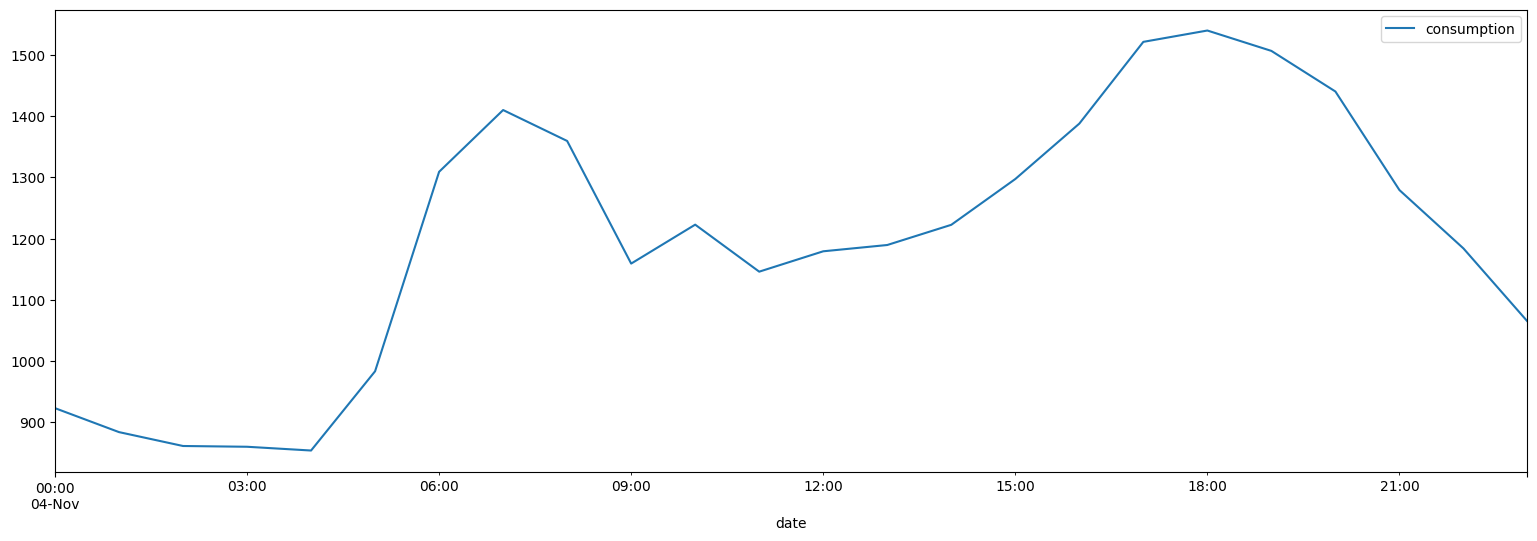

In [129]:
# y_test.index = date['date']
forecast.plot(figsize=(19, 6),legend=True)
# ax = y_test.plot(title=plt_title,figsize=(19, 6), legend=True, x=date['date'])
# add date to plot as x axis

In [130]:
forecast.to_csv('outputs/output_11-04.csv', header=None)